## Matrix multiplication from foundations

## Multiplicação de matrizes somente com o fundamental

The *foundations* we'll assume throughout this course are:

- Python
- Python modules (non-DL)
- pytorch indexable tensor, and tensor creation (including RNGs)
- fastai.datasets

Os *fundamentos* que assumimos ao longo deste curso são:

- Python
- módulos Python (Exceto DL)
- tensor indexável do pytorch e criação de tensores (incluindo Gerador de Números Pseudo-Aleatórios)
- fastai.datasets

## Check imports

## Importações

In [1]:
%load_ext autoreload
%autoreload 2

%matplotlib inline

In [2]:
#export
from exp.nb_00 import *
import operator

def test(a,b,cmp,cname=None):
    if cname is None: cname=cmp.__name__
    assert cmp(a,b),f"{cname}:\n{a}\n{b}"

def test_eq(a,b): test(a,b,operator.eq,'==')

In [3]:
test_eq(TEST,'test')

In [ ]:
# To run tests in console:
# ! python run_notebook.py 01_matmul.ipynb

## Get data

In [4]:
#export
from pathlib import Path
from IPython.core.debugger import set_trace
from fastai import datasets
import pickle, gzip, math, torch, matplotlib as mpl
import matplotlib.pyplot as plt
from torch import tensor

MNIST_URL='http://deeplearning.net/data/mnist/mnist.pkl'

In [5]:
path = datasets.download_data(MNIST_URL, ext='.gz'); path

PosixPath('/content/clouderizer/fastai-1.0/data/mnist.pkl.gz')

In [6]:
with gzip.open(path, 'rb') as f:
    ((x_train, y_train), (x_valid, y_valid), _) = pickle.load(f, encoding='latin-1')

In [7]:
x_train,y_train,x_valid,y_valid = map(tensor, (x_train,y_train,x_valid,y_valid))
n,c = x_train.shape
x_train, x_train.shape, y_train, y_train.shape, y_train.min(), y_train.max()

(tensor([[0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         ...,
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.]]),
 torch.Size([50000, 784]),
 tensor([5, 0, 4,  ..., 8, 4, 8]),
 torch.Size([50000]),
 tensor(0),
 tensor(9))

In [8]:
assert x_train.shape[0]==y_train.shape[0]==50000
test_eq(x_train.shape[1],28*28)
test_eq(y_train.min(),0)
test_eq(y_train.max(),9)

In [9]:
mpl.rcParams['image.cmap'] = 'gray'

In [10]:
img = x_train[0]

In [11]:
img.view(28,28).type()

'torch.FloatTensor'

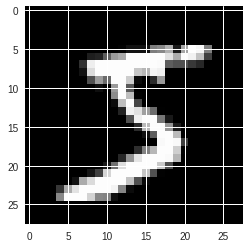

In [12]:
plt.imshow(img.view((28,28)));

## Initial python model

In [15]:
weights = torch.randn(784,10)/math.sqrt(784)

In [16]:
bias = torch.zeros(10)

#### Matrix multiplication

In [17]:
def matmul(a,b):
    ar,ac = a.shape # n_rows * n_cols
    br,bc = b.shape
    assert ac==br
    c = torch.zeros(ar, bc)
    for i in range(ar):
        for j in range(bc):
            for k in range(ac): # or br
                c[i,j] += a[i,k] * b[k,j]
    return c

In [18]:
m1 = x_valid[:5]
m2 = weights

In [19]:
m1.shape,m2.shape

(torch.Size([5, 784]), torch.Size([784, 10]))

In [20]:
%time t1=matmul(m1, m2)

CPU times: user 628 ms, sys: 1.39 ms, total: 629 ms
Wall time: 635 ms


In [21]:
len(x_train)

50000

#### Elementwise ops

Operators (+,-,\*,/,>,<,==) are usually element-wise.

Examples of element-wise operations:

In [22]:
a = tensor([10., 6, -4])
b = tensor([2., 8, 7])
a,b

(tensor([10.,  6., -4.]), tensor([2., 8., 7.]))

In [23]:
a + b

tensor([12., 14.,  3.])

In [24]:
(a < b).float().mean()

tensor(0.6667)

In [25]:
m = tensor([[1., 2, 3], [4,5,6], [7,8,9]]); m

tensor([[1., 2., 3.],
        [4., 5., 6.],
        [7., 8., 9.]])

Frobenius norm:

$\| A \|_F = \left( \sum_{i,j=1}^n | a_{ij} |^2 \right)^{1/2}$

*Hint*: you don't normally need to write equations in LaTeX yourself, instead, you can click 'edit' in Wikipedia and copy the LaTeX from there (which is what I did for the above equation). Or on arxiv.org, click "Download: Other formats" in the top right, then "Download source"; rename the downloaded file to end in `.tgz` if it doesn't already, and you should find the source there, including the equations to copy and paste.

Norma Frobenius:

$\| A \|_F = \left( \sum_{i,j=1}^n | a_{ij} |^2 \right)^{1/2}$

*Sugestão*: você não precisa escrever equações no LaTeX, você pode clicar em 'editar' na Wikipedia e copiar o LaTeX de lá (o que eu fiz para a equação acima). Ou em arxiv.org, clique em "Download: Outros formatos" no canto superior direito, depois em "Baixar fonte"; renomeie o arquivo baixado para terminar em `.tgz` se ele ainda não existir, e você deve encontrar a fonte lá, incluindo as equações para copiar e colar.

In [26]:
(m*m).sum().sqrt()

tensor(16.8819)

#### Elementwise matmul

#### Elementwise matmul

In [28]:
def matmul(a,b):
    ar,ac = a.shape
    br,bc = b.shape
    assert ac==br
    c = torch.zeros(ar, bc)
    for i in range(ar):
        for j in range(bc):
            # Any trailing ",:" can be removed
            c[i,j] = (a[i,:] * b[:,j]).sum()
    return c

In [29]:
%timeit -n 10 _=matmul(m1, m2)

10 loops, best of 3: 1.19 ms per loop


In [30]:
#export
def near(a,b): return torch.allclose(a, b, rtol=1e-3, atol=1e-5)
def test_near(a,b): test(a,b,near)

In [31]:
test_near(t1,matmul(m1, m2))

### Broadcasting

The term **broadcasting** describes how arrays with different shapes are treated during arithmetic operations.  The term broadcasting was first used by Numpy.

From the [Numpy Documentation](https://docs.scipy.org/doc/numpy-1.10.0/user/basics.broadcasting.html):

    The term broadcasting describes how numpy treats arrays with 
    different shapes during arithmetic operations. Subject to certain 
    constraints, the smaller array is “broadcast” across the larger 
    array so that they have compatible shapes. Broadcasting provides a 
    means of vectorizing array operations so that looping occurs in C
    instead of Python. It does this without making needless copies of 
    data and usually leads to efficient algorithm implementations.
    
In addition to the efficiency of broadcasting, it allows developers to write less code, which typically leads to fewer errors.

*This section was adapted from [Chapter 4](http://nbviewer.jupyter.org/github/fastai/numerical-linear-algebra/blob/master/nbs/4.%20Compressed%20Sensing%20of%20CT%20Scans%20with%20Robust%20Regression.ipynb#4.-Compressed-Sensing-of-CT-Scans-with-Robust-Regression) of the fast.ai [Computational Linear Algebra](https://github.com/fastai/numerical-linear-algebra) course.*

#### Broadcasting with a scalar

In [32]:
a

tensor([10.,  6., -4.])

In [33]:
a > 0

tensor([1, 1, 0], dtype=torch.uint8)

How are we able to do a > 0?  0 is being **broadcast** to have the same dimensions as a.

Remember above when we normalized our dataset by subtracting the mean (a scalar) from the entire data set (a matrix) and dividing by the standard deviation (another scalar)?  We were using broadcasting!

Other examples of broadcasting with a scalar:

In [34]:
a + 1

tensor([11.,  7., -3.])

In [35]:
m

tensor([[1., 2., 3.],
        [4., 5., 6.],
        [7., 8., 9.]])

In [36]:
2*m

tensor([[ 2.,  4.,  6.],
        [ 8., 10., 12.],
        [14., 16., 18.]])

#### Broadcasting a vector to a matrix

We can also broadcast a vector to a matrix:

In [37]:
c = tensor([10.,20,30]); c

tensor([10., 20., 30.])

In [38]:
m

tensor([[1., 2., 3.],
        [4., 5., 6.],
        [7., 8., 9.]])

In [39]:
m.shape,c.shape

(torch.Size([3, 3]), torch.Size([3]))

In [40]:
m + c

tensor([[11., 22., 33.],
        [14., 25., 36.],
        [17., 28., 39.]])

In [41]:
c + m

tensor([[11., 22., 33.],
        [14., 25., 36.],
        [17., 28., 39.]])

We don't really copy the rows, but it looks as if we did. In fact, the rows are given a *stride* of 0.

In [42]:
t = c.expand_as(m)

In [43]:
t

tensor([[10., 20., 30.],
        [10., 20., 30.],
        [10., 20., 30.]])

In [44]:
m + t

tensor([[11., 22., 33.],
        [14., 25., 36.],
        [17., 28., 39.]])

In [45]:
t.storage()

 10.0
 20.0
 30.0
[torch.FloatStorage of size 3]

In [46]:
t.stride(), t.shape

((0, 1), torch.Size([3, 3]))

You can index with the special value [None] or use `unsqueeze()` to convert a 1-dimensional array into a 2-dimensional array (although one of those dimensions has value 1).

In [ ]:
c.shape, c.unsqueeze(0).shape,c.unsqueeze(1).shape